In [52]:
from netCDF4 import Dataset
#from mpl_toolkits.basemap import Basemap#, cm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
import os
import time
from matplotlib.ticker import PercentFormatter
#from matplotlib.colors import LinearSegmentedColormap
#from matplotlib import cm
#from matplotlib.patches import Polygon
#from matplotlib.patches import Patch
#from matplotlib.lines import Line2D
#from matplotlib.ticker import FormatStrFormatter
#import warnings
#warnings.filterwarnings("ignore")

def cm2inch(value):
    return value/2.54

def rot2geo(xin,yin):


    pollon=-170.
    pollat=40.
    xgeo=[i for i in xin]
    ygeo=[i for i in yin]

    for i in range(len(xin)):
        ygeo[i]=180./math.pi * math.asin(math.sin(math.pi/180.*yin[i])*math.sin(math.pi/180.*pollat) + math.cos(math.pi/180.*yin[i])*math.cos(math.pi/180.*xin[i])*math.cos(math.pi/180.*pollat))

        xgeo[i]=180./math.pi * math.atan((math.cos(math.pi/180.*yin[i])*math.sin(math.pi/180.*xin[i]))/(math.sin(math.pi/180.*pollat)*math.cos(math.pi/180.*yin[i])*math.cos(math.pi/180.*xin[i])-math.sin(math.pi/180.*yin[i])*math.cos(math.pi/180.*pollat))) + pollon + 180

    return(xgeo,ygeo)

def meter2grad(meter):
    grad=np.zeros(len(meter))
    for i in range(len(meter)):
        grad[i] = meter[i]/6.3710088e6 * 180./np.pi
    return grad

def grad2meter(grad):
    meter=np.zeros(len(grad))
    for i in range(len(grad)):
        meter[i] = grad[i]*6.3710088e6 * np.pi/180.
    return meter

In [53]:
totaltime=time.time()
print()
print('Start')
print('│')
print('├──read data')
stime=time.time()
files = []
for (dirpath, dirnames, filenames) in os.walk("."):
    files.extend(filenames)


files=sorted(files)
namelist=[]
# datestring=[]
for name in files:
    if name[-3:]=='.nc' and name[:4]=='part':
        namelist.append(name)
        # datestring.append(name[5:-3])

nfile=0
timesave=0
timediff=0
for fn in namelist[:]:
    nfile+=1
    print('│  │ '+fn)
    datestring=fn[5:-3]


    # data input
    f=Dataset(fn,'r')
    intime = f.variables['time'][:]
    inz    = f.variables['z'][:]          # [m]
    inzrel = f.variables['zrel'][:]          # [m]
    inlat  = f.variables['latitude'][:]   # [rotlat]
    inlon  = f.variables['longitude'][:]  # [rotlon]
    insize = f.variables['size'][:]  # [rotlon]


    if nfile == 1:
        timesave=len(intime)
        z=np.asarray(inz)
        zrel=np.asarray(inzrel)
        rlat=np.asarray(inlat)
        rlon=np.asarray(inlon)
        size=np.asarray(insize)
    else:
        timediff=timesave-len(intime)
        if timediff != 0:
            dim=inz.shape

            oz    = np.zeros((timediff,dim[1]))
            ozrel = np.zeros((timediff,dim[1]))
            olat  = np.zeros((timediff,dim[1]))
            olon  = np.zeros((timediff,dim[1]))

            oz[:,:]   = inz[1][:]
            ozrel[:,:]= inz[1][:]
            olat[:,:] = inlat[0][:]
            olon[:,:] = inlon[0][:]

            inz[0][:]=inz[1][:]
            inzrel[0][:]=inzrel[1][:]

            inz   = np.concatenate((oz  ,np.asarray(inz)),   axis=0)
            inzrel= np.concatenate((ozrel  ,np.asarray(inzrel)),   axis=0)
            inlat = np.concatenate((olat,np.asarray(inlat)), axis=0)
            inlon = np.concatenate((olon,np.asarray(inlon)), axis=0)

        z=np.concatenate((z,np.asarray(inz)), axis=1)
        zrel=np.concatenate((zrel,np.asarray(inzrel)), axis=1)
        rlat=np.concatenate((rlat,np.asarray(inlat)), axis=1)
        rlon=np.concatenate((rlon,np.asarray(inlon)), axis=1)
        size=np.concatenate((size,np.asarray(insize)), axis=0)




    f.close()

print('│  done '+str(int(time.time()-stime))+'s')
print('│')



Start
│
├──read data
│  │ part_2017053111.nc
│  │ part_2017053112.nc
│  done 8s
│


In [54]:
print('├──find start and end points')
stime=time.time()

dimz=z.shape



# list that holds the pure trajetory information,
# without dead spaces before start and after dead of traj
tra=[]
trasize=[]
idc=-1
tstartsecondpart=0
for id in range(0,dimz[1]):
    tstart=0
    idc+=1
    # print(id,idc)
    par=np.zeros((1,4))
    tra.append(par)
    trasize.append(size[id])

    # for identify position when the particle is dead
    first=True

    # time loop
    for t in range(dimz[0]):
        if t > 1:# and t < dimz[0]-2:
            if first and z[t][id] != z[0][id] and z[t][id] != z[1][id]:# and z[t][id] != z[t+1][id]:
                par[0,:]=[rlon[t-1][id],rlat[t-1][id],z[t-1][id],zrel[t-1][id]]
                if tstartsecondpart > 0:
                    for i in range(t-tstartsecondpart):
                        par=np.append(par,[[rlon[t-1][id],rlat[t-1][id],z[t-1][id],zrel[t-1][id]]],0)
                        #par=np.append(par,[[rlon[t-1][id],rlat[t-1][id],np.nan,np.nan]],0)

                first=False
                if id > 0 and tstartsecondpart==0:
                    tstartsecondpart=t



            if not first and z[t][id] != z[t-1][id]:
                par=np.append(par,[[rlon[t][id],rlat[t][id],z[t][id],zrel[t][id]]],0)
                tra[idc]=par
            if not first and z[t][id] == z[t-1][id]:
                break


print('│  └─done '+str(int(time.time()-stime))+'s')
print('│')

├──find start and end points
│  └─done 201s
│


In [55]:
print(len(tra))

43820


In [56]:
# define stat values
st_max_height = np.zeros(len(tra))
st_mean_height = np.zeros(len(tra))
st_distance_2d = np.zeros(len(tra))
st_distance_z = np.zeros(len(tra))
st_time = np.zeros(len(tra))

st_test = np.zeros(10000)

nid=0
for tr in tra:
    st_max_height[nid] = np.max(tr[:,3])
    st_mean_height[nid] = np.mean(tr[:,3])
    
    tra_len=tr.shape[0]
    
    for t in range(1,tra_len):
        x = np.abs(tr[t,0]-tr[t-1,0])
        y = np.abs(tr[t,1]-tr[t-1,1])
        z = np.abs(tr[t,3]-tr[t-1,3])
        st_distance_2d[nid]+=np.sqrt(x**2+y**2)*6.3710088*10**6 * np.pi/180.
        st_distance_z[nid]+=z
        st_time[nid]+=1./60

    nid+=1
    

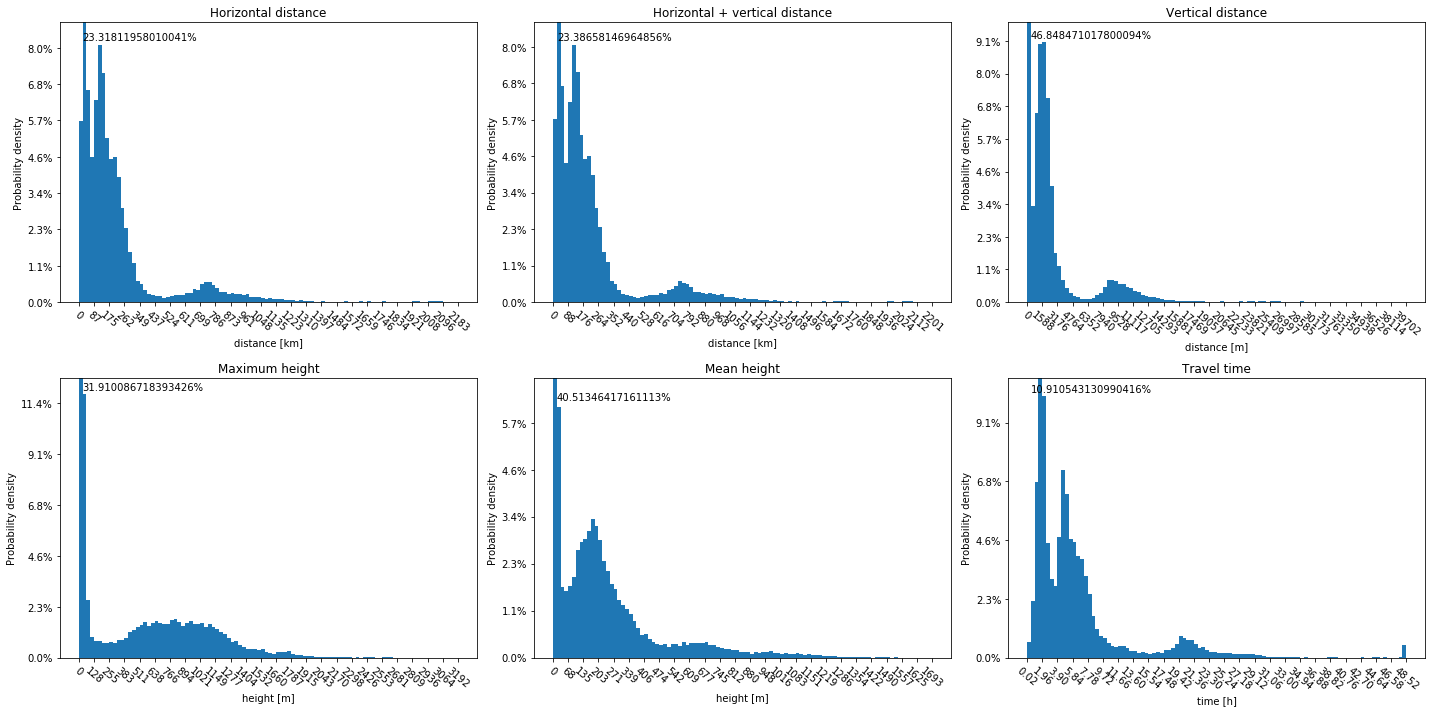

In [57]:
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)



# the histogram of the data

num_bins=100

# maximum height
n, bins, patches = ax[1,0].hist(st_max_height, num_bins)#, density=True)
numhist=np.histogram(st_max_height, num_bins)
ax[1,0].set_title('Maximum height')
ax[1,0].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_max_height)*0.007])
ax[1,0].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
ax[1,0].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_max_height)))
ax[1,0].set_ylabel('Probability density')
ax[1,0].set_xlabel('height [m]')
ax[1,0].set_xticks(numhist[1][0::4])
plt.setp(ax[1,0].xaxis.get_majorticklabels(), rotation=-40)

# mean height
n, bins, patches = ax[1,1].hist(st_mean_height, num_bins)#, density=True)
numhist=np.histogram(st_mean_height, num_bins)
ax[1,1].set_title('Mean height')
ax[1,1].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_mean_height)*0.007])
ax[1,1].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_mean_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_mean_height)*100)+'%')
ax[1,1].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_mean_height)))
ax[1,1].set_ylabel('Probability density')
ax[1,1].set_xlabel('height [m]')
ax[1,1].set_xticks(numhist[1][0::4])
plt.setp(ax[1,1].xaxis.get_majorticklabels(), rotation=-40)

# Horizontal distance
n, bins, patches = ax[0,0].hist(st_distance_2d/1000, num_bins)#, density=True)
numhist=np.histogram(st_distance_2d/1000, num_bins)
ax[0,0].set_title('Horizontal distance')
ax[0,0].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_max_height)*0.007])
ax[0,0].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
ax[0,0].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_max_height)))
ax[0,0].set_ylabel('Probability density')
ax[0,0].set_xlabel('distance [km]')
ax[0,0].set_xticks(numhist[1][0::4])
plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=-40)

# Vertical distance
n, bins, patches = ax[0,2].hist(st_distance_z, num_bins)#, density=True)
numhist=np.histogram(st_distance_z, num_bins)
ax[0,2].set_title('Vertical distance')
ax[0,2].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_max_height)*0.007])
ax[0,2].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
ax[0,2].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_max_height)))
ax[0,2].set_ylabel('Probability density')
ax[0,2].set_xlabel('distance [m]')
ax[0,2].set_xticks(numhist[1][0::4])
plt.setp(ax[0,2].xaxis.get_majorticklabels(), rotation=-40)


# Horizontal + vertical distance
n, bins, patches = ax[0,1].hist(st_distance_2d/1000+st_distance_z/1000, num_bins)#, density=True)
numhist=np.histogram(st_distance_2d/1000+st_distance_z/1000, num_bins)
ax[0,1].set_title('Horizontal + vertical distance')
ax[0,1].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_max_height)*0.007])
ax[0,1].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
ax[0,1].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_max_height)))
ax[0,1].set_ylabel('Probability density')
ax[0,1].set_xlabel('distance [km]')
ax[0,1].set_xticks(numhist[1][0::4])
plt.setp(ax[0,1].xaxis.get_majorticklabels(), rotation=-40)

# Travel time
n, bins, patches = ax[1,2].hist(st_time, num_bins)#, density=True)
numhist=np.histogram(st_time, num_bins)
ax[1,2].set_title('Travel time')
ax[1,2].set_ylim([0,sorted(numhist[0][:])[-2]+len(st_max_height)*0.007])
ax[1,2].text(numhist[1][1],sorted(numhist[0][:])[-2]+len(st_max_height)*0.0015,str(sorted(numhist[0][:])[-1]/len(st_max_height)*100)+'%')
ax[1,2].yaxis.set_major_formatter(PercentFormatter(xmax=len(st_max_height)))
ax[1,2].set_ylabel('Probability density')
ax[1,2].set_xlabel('time [h]')
ax[1,2].set_xticks(numhist[1][0::4])
plt.setp(ax[1,2].xaxis.get_majorticklabels(), rotation=-40)

# Tweak spacing to prevent clipping of ylabel

#plt.savefig('0hist/'+cluster_name[ncs]+'_'+datestring+'.pdf')
plt.show()